In [1]:
import sys
sys.path.append('../..')
sys.path.append('../../APDFT')
sys.path.append('../../helper_code')
sys.path.append('../data')

import pickle
from pyscf import gto, scf, dft, cc
from ase import Atoms
import numpy as np
import pandas as pd
import pyscf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import basis_set_exchange as bse
from APDFT.FcMole import *
import os
import ast
from copy import deepcopy
from IPython.display import display
from helper_code.data_processing import *


%load_ext autoreload
%autoreload 2
from APDFT.AP_class import APDFT_perturbator as AP

/home/gabrielwu2004/.local/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


## Load Dataset ##

In [28]:
coronene_energy_raw_data = np.load("../data/coronene_raw_data/coronene_mutants_pbe_pcx2_corrected2.npz", allow_pickle=True)
charges, total_energy = coronene_energy_raw_data['charges'], coronene_energy_raw_data['energies']

columns = ['charges', 'total energy']
coronene_energy_data = pd.DataFrame(columns=columns)
coronene_energy_data['charges'] = charges.tolist()
coronene_energy_data['total energy'] = total_energy.tolist()

CORONENE_REF_ENERGY = -921.076917318163
coronene_energy_data['delta total energy'] = coronene_energy_data['total energy'].apply(lambda x: CORONENE_REF_ENERGY-x)

hessian_data = np.load("coronene_pbe_pcX2_hessian.npz", allow_pickle=True)
g, H = hessian_data['g'], hessian_data['H']
ANM_eigval, Q = np.linalg.eig(H)
Q_inv = np.linalg.inv(Q)


coronene_energy_data['dx'] = None
coronene_energy_data['APDFT2'] = None
coronene_energy_data['DD e_tot'] = None
coronene_energy_data['DD e_tot (kcal/mol)'] = None

HA_TO_KCAL = 627.5096080305927
for index, row in coronene_energy_data.iterrows():
    ref_charge = np.full(24, 6)
    dx = np.array(row['charges'][:24]) - ref_charge
    apdft2 = CORONENE_REF_ENERGY + dx.dot(g) + 0.5*np.einsum('i,ij,j', dx, H ,dx)
    target_energy = coronene_energy_data.at[index, 'total energy']
    coronene_energy_data.at[index, 'dx'] = dx
    coronene_energy_data.at[index, 'APDFT2'] = apdft2
    coronene_energy_data.at[index, 'DD e_tot'] = apdft2 - target_energy
    coronene_energy_data.at[index, 'DD e_tot (kcal/mol)'] = coronene_energy_data.at[index, 'DD e_tot'] * HA_TO_KCAL


print(f"num row: {coronene_energy_data.shape[0]}")
display(coronene_energy_data.head(3))

num row: 1476


,charges,total energy,delta total energy,dx,APDFT2,DD e_tot,DD e_tot (kcal/mol)
0,"[6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, ...",-924.410553,3.333636,"[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",-924.400048,0.010505,6.592014
1,"[6, 7, 6, 6, 6, 7, 6, 5, 6, 6, 5, 5, 6, 7, 7, ...",-941.200990,20.124073,"[0, 1, 0, 0, 0, 1, 0, -1, 0, 0, -1, -1, 0, 1, ...",-941.15276,0.04823,30.264636
2,"[7, 5, 5, 6, 6, 5, 7, 7, 5, 6, 5, 5, 7, 7, 7, ...",-951.609019,30.532102,"[1, -1, -1, 0, 0, -1, 1, 1, -1, 0, -1, -1, 1, ...",-951.446278,0.162741,102.121688


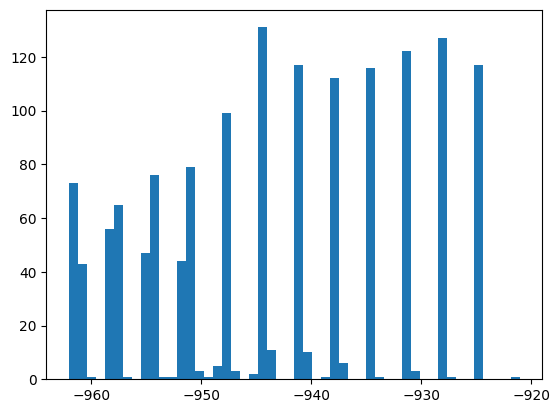

In [11]:
plt.hist(coronene_energy_data['total energy'].tolist(), bins=50)
plt.show()

21.725684614354357
11.500848035117201


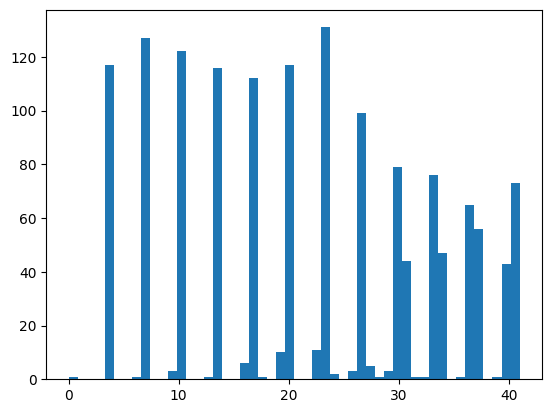

In [22]:
print(np.array(coronene_energy_data['delta total energy'].mean()))
print(np.array(coronene_energy_data['delta total energy'].std()))
plt.hist(coronene_energy_data['delta total energy'].tolist(), bins=50)
plt.show()

0.08103157796456763
0.37987876528885106


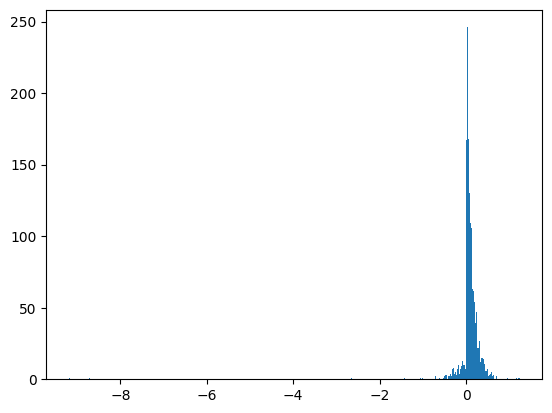

In [21]:
print(np.array(coronene_energy_data['DD e_tot'].mean()))
print(np.array(coronene_energy_data['DD e_tot'].std()))
plt.hist(coronene_energy_data['DD e_tot'].tolist(), bins='auto')
plt.show()

In [40]:
max = np.max(coronene_energy_data['DD e_tot'])
q1 = np.percentile(coronene_energy_data['DD e_tot'], 25)
median = np.percentile(coronene_energy_data['DD e_tot'], 50)
q3 = np.percentile(coronene_energy_data['DD e_tot'], 75)
min = np.min(coronene_energy_data['DD e_tot'])


print("Minimum value:", min)
print("25th percentile (Q1):", q1)
print("Median (Q2):", median)
print("75th percentile (Q3):", q3)
print("Maximum value:", max)

Minimum value: -9.198290540712264
25th percentile (Q1): 0.021164203026643236
Median (Q2): 0.07038510687402777
75th percentile (Q3): 0.16075005338959159
Maximum value: 1.2392988222109125


In [38]:
print(np.array(coronene_energy_data['DD e_tot (kcal/mol)'].mean()))
print(np.array(coronene_energy_data['DD e_tot (kcal/mol)'].std()))

50.84809372664628
238.3775751055524


## Data Processing ##

In [23]:
rotation_mapping = {0:21, 21:22, 22:15, 15:12, 12:7, 7:0, 
                    1:20, 20:23, 23:14, 14:13, 13:6, 6:1,
                    2:19, 19:16, 16:11, 11:8, 8:5, 5:2,
                    3:18, 18:17, 17:10, 10:9, 9:4, 4:3}

reflection_mapping1 = {0:6, 6:0, 7:1, 1:7, 5:5, 
                       8:2, 2:8, 4:4, 13:21, 21:13,
                       9:3, 3:9, 12:20, 20:12, 10:18, 18:10,
                       11:19, 19:11, 17:17, 14:22, 22:14, 16:16,
                       15:23, 23:15}

reflection_mapping2 = {0:1, 1:0, 6:21, 21:6, 5:2, 2:5,
                       7:20, 20:7, 4:3, 3:4, 8:19, 19:8,
                       9:18, 18:9, 13:22, 22:13, 10:17, 17:10,
                       12:23, 23:12, 11:16, 16:11, 14:15, 15:14}

In [30]:
coronene_energy_data['dx_lexi'] = coronene_energy_data['dx'].apply(
    lambda arr: coronene_lexi(arr.tolist(), rotation_mapping, reflection_mapping1, reflection_mapping2))

coronene_energy_data['c'] = coronene_energy_data['dx'].apply(
    lambda arr: (arr.reshape(1, 24)@Q).reshape(24,).tolist()) # column vector view: c = Q_inv @ dx

coronene_energy_data['c_lexi'] = coronene_energy_data['dx_lexi'].apply(
    lambda arr: (arr.reshape(1, 24)@Q).reshape(24,).tolist())

coronene_energy_data['CE'] = coronene_energy_data['c'].apply(
    lambda arr: compute_lambda_c(arr, ANM_eigval))

coronene_energy_data['CE_lexi'] = coronene_energy_data['c_lexi'].apply(
    lambda arr: compute_lambda_c(arr, ANM_eigval))

coronene_energy_data['CSE'] = coronene_energy_data['c'].apply(
    lambda arr: compute_lambda_c_square(arr, ANM_eigval))

coronene_energy_data['CSE_lexi'] = coronene_energy_data['c_lexi'].apply(
    lambda arr: compute_lambda_c_square(arr, ANM_eigval))

[-2.0293923287158615e-06, 0.18315185635559242, 0.895190552879729, 0.07287926351269419, 0.20686517757052222, 0.005687774119886055, 0.27228138755121656, 0.006863161752118969, 0.7660077921531, 0.07345996268491743, 0.006410584824738454, 0.46466874516634094, 0.2306104016819049, 1.2263779419199043, 0.001714419563818302, 0.28435854242730596, 0.054862135930830905, 0.1864242381586431, 0.036625646235275006, 0.3682200813097333, 0.38785923324730887, 0.7722874082666297, 0.05714390241518255, 0.06669827751214517]


## Export Data ##

In [31]:
datasets = ['c', 'c_lexi', 'CE', 'CE_lexi', 'CSE', 'CSE_lexi']
columns = [f"coord{i}" for i in range(24)]

dataset_dict = {}
for data in datasets:
    dataset_dict[data] = pd.DataFrame(columns=columns)
    for i in range(24):
        dataset_dict[data][f"coord{i}"] = coronene_energy_data[data].apply(lambda arr: arr[i])

# display(dataset_dict['CSE_lexi'])

In [33]:
for key, dataframe in dataset_dict.items():
    dataframe.to_csv(f'../data/coronene_training_data/{key}.csv', index=False)

In [34]:
coronene_energy_data['delta total energy'].to_csv('../data/coronene_training_data/delta_total_energy.csv', index=False)
coronene_energy_data['DD e_tot'].to_csv('../data/coronene_training_data/DD e_tot.csv', index=False)

## dx Uniqueness ##

In [36]:
from scipy.spatial.distance import cdist

dx_matrix = np.vstack(coronene_energy_data['dx'].tolist())
dx_lexi_matrix = np.vstack(coronene_energy_data['dx_lexi'].tolist())

# Calculate pairwise Euclidean distances between rows
dist_matrix = cdist(dx_lexi_matrix, dx_lexi_matrix, metric='euclidean')
np.fill_diagonal(dist_matrix, None)

zero_count = 0
for i in range(dist_matrix.shape[0]):
    for j in range(dist_matrix.shape[1]):
        if dist_matrix[i][j] == 0:
            zero_count += 1
            print("Identity:")
            print("dx 1: ", dx_matrix[i])
            print("dx 2: ", dx_matrix[j])
            print("resulting lexi mapping 1: ", dx_lexi_matrix[i])
            print("resulting lexi mapping 2: ", dx_lexi_matrix[j])
            print("energy of dx 1:", coronene_energy_data['delta total energy'][i])
            print("energy of dx 2:", coronene_energy_data['delta total energy'][j])
            print("delta delta energy of dx1:", coronene_energy_data['DD e_tot'][i])
            print("delta delta energy of dx2:", coronene_energy_data['DD e_tot'][j])
            print()
print("zero count:", zero_count)

Identity:
dx 1:  [ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
dx 2:  [ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
resulting lexi mapping 1:  [ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
resulting lexi mapping 2:  [ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
energy of dx 1: 3.3336360719493996
energy of dx 2: 3.3336264673079086
delta delta energy of dx1: 0.010505040254543019
delta delta energy of dx2: 0.010540132473465746

Identity:
dx 1:  [ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
dx 2:  [ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
resulting lexi mapping 1:  [ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
resulting lexi mapping 2:  [ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
energy of dx 1: 3.3336360719493996
energy of dx 2: 3.3336255932064205
delta delta ene

In [37]:
target_array = [0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0]

mask = coronene_energy_data['dx_lexi'].apply(lambda arr: arr.tolist() == target_array)
# display(mask)
coronene_energy_data.loc[mask, ['dx', 'dx_lexi', 'total energy']]

,dx,dx_lexi,total energy
297,"[0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-924.438154
707,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0,...","[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-924.438160


## Feature Distribution ##

[ 2.20000000e+00 -1.16415601e-03 -1.03283839e+00 ... -1.96144872e-01
  3.16074214e-01  8.27182623e-01]


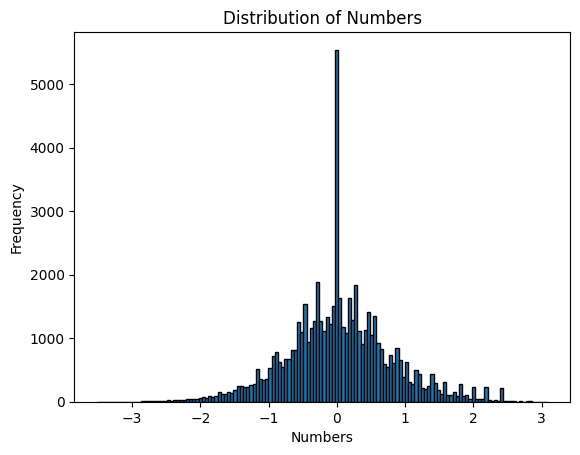

In [15]:
C = np.vstack(coronene_energy_data['c_lexi_nd'].tolist()).flatten()
print(C)
# Plot the histogram
plt.hist(C, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()

[ 2.20000000e+00 -3.67728801e-06  8.86895734e-01 ...  5.84328154e-02
  1.46301129e-01  1.00201119e+00]


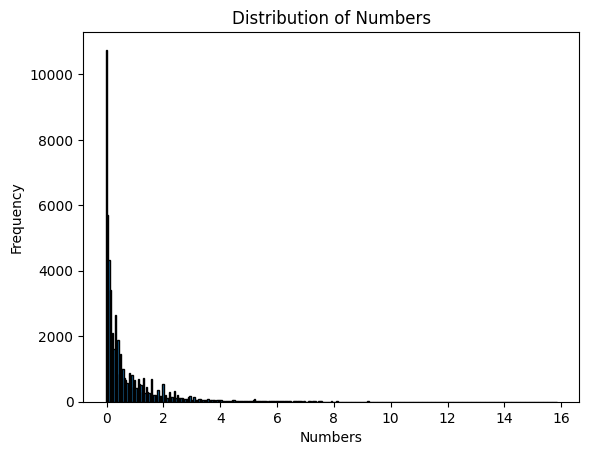

In [13]:
CSE = np.vstack(coronene_energy_data['CSE_lexi_nd'].tolist()).flatten()
print(CSE)
# Plot the histogram
plt.hist(CSE, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()

[ 2.2         0.00315876 -0.85869749 ... -0.29790641  0.46286955
  1.21135426]


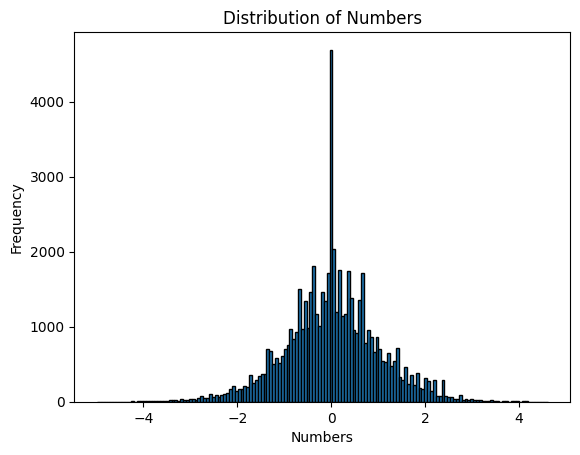

In [14]:
CE = np.vstack(coronene_energy_data['CE_lexi_nd'].tolist()).flatten()
print(CE)
# Plot the histogram
plt.hist(CE, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()

## Target Distribution ##

[5.51636722 3.32582915 6.99704056 ... 5.10960113 2.21484455 2.54989888]
mean: 4.260245676354518
minimum: 0.5798839771400259
maximum: 12.875830435434946
std: 2.462527263064554


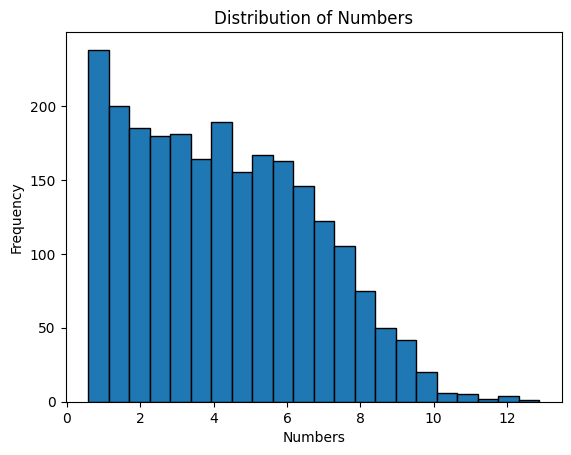

In [23]:
delta_delta = np.array(coronene_energy_data['delta delta total energy']).flatten()
print(delta_delta)
print("mean:", delta_delta.mean())
print("minimum:", delta_delta.min())
print("maximum:", delta_delta.max())
print("std:", delta_delta.std())
# Plot the histogram
plt.hist(delta_delta, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()